$\textbf{Short Discription:}$  
This Jupyter notebook primarily focuses on the implementation of BiT model and its application to the Image Classification problem. The model was trained on the dataset "is-that-santa" from Kaggle. The preprocessing pipeline encompasses the selection of image size and dataset size, defining training steps and scheduling, and so on. . The experiment evaluates the model's performance across various scenarios, including training for 10 epochs, 30 epochs, applying image rotation for 10 epochs, and employing grayscale images for 10 epochs.

# Import libraries 

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import os
import random
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
import imghdr
import keras
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

d:\software\python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data 
Kaggle Dataset: is that santa? (https://www.kaggle.com/datasets/deepcontractor/is-that-santa-image-classification) 

This part is to load the data and check the format of the images and remove them if they can not be accepted


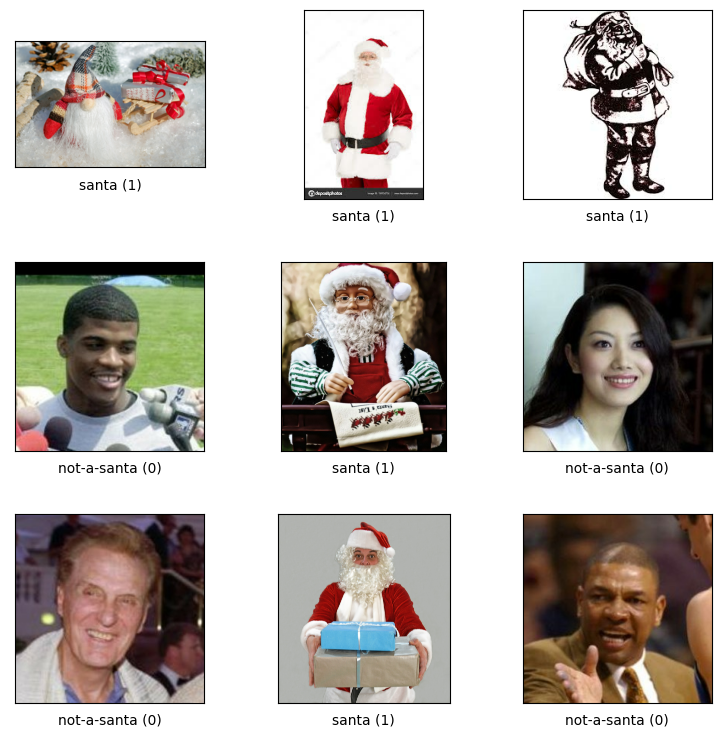

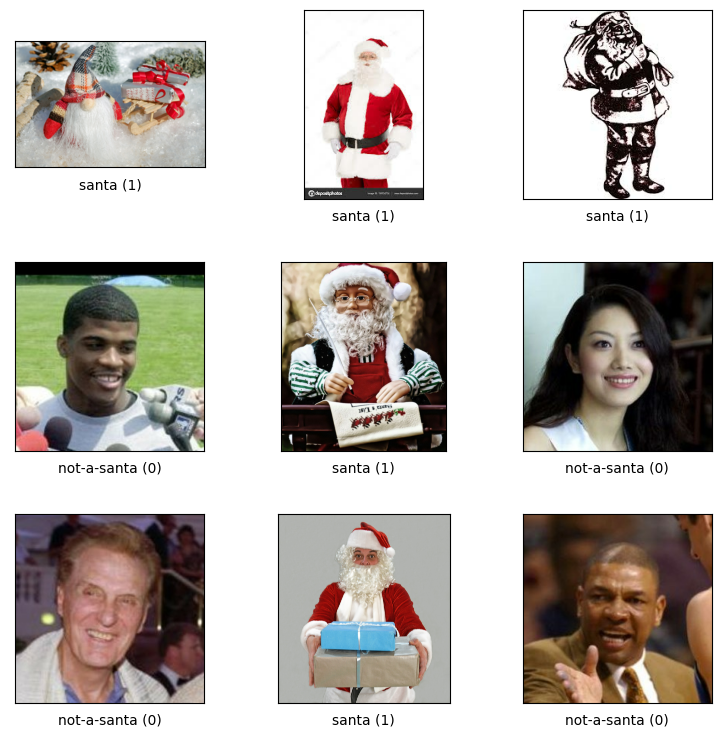

In [10]:
data_dir = 'D:\git\computer vision\img classification with BiT model\is-that-santa-image-classification'
image_extensions = [".png", ".jpg"]  


# check the format of the images and remove them if they can not be accepted
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

    
#Build a tensorflow dataset using the uploaded images
build = tfds.ImageFolder(data_dir+'/is that santa')
# print(build.info)
train_data = build.as_dataset(split='train', shuffle_files=True)
test_data = build.as_dataset(split='test', shuffle_files=True)

#Show some images in the training dataset
tfds.show_examples(train_data, build.info)

# BiT model

## trained with 10 epochs

In [11]:
#Learn a classifier by finetuning a BiT-M model (ResNet50x1 model trained on ImageNet-21k)
module=hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1")
#Create a new model with a new final layer that has the correct number of output classes
class BiT(tf.keras.Model):
  def __init__(self, num_classes, mod):
    super().__init__()
    self.num_classes=num_classes
    self.head=tf.keras.layers.Dense(num_classes,kernel_initializer='zeros')
    self.bit_model=mod
  
  def call(self,images):
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)
model=BiT(num_classes=2,mod=module)

#Fine-tune this model using BiT-HyperRule 
image_size = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
#Alternatively, set image_size = "> 96 x 96 px" #@param ["=<96x96 px","> 96 x 96 px"]
dataset_size = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]
# Resize and crop images

# running on vs
image_size = "=<96x96 px"
dataset_size = "<20k examples"
if image_size == "=<96x96 px":
  resize_to = 160
  crop_to = 128
else:
  resize_to = 512
  crop_to = 480
#Training steps
if dataset_size == "<20k examples":
  schedule_length = 500
  schedule_boundaries = [200, 300, 400]
elif dataset_size == "20k-500k examples":
  schedule_length = 10000
  schedule_boundaries = [3000, 6000, 9000]
else:
  schedule_length = 20000
  schedule_boundaries = [6000, 12000, 18000]



#Preprocessing
batch_size = 10
schedule_length = schedule_length * 512 / batch_size
steps_per_epoch= 10


def cast_to_tuple(features):
  return (features['image'], features['label'])

#Preprocess train  images
def preprocess_train(features):
  #Apply horizontal flips
  features['image'] = tf.image.random_flip_left_right(features['image'])
  #Resize
  features['image'] = tf.image.resize(features['image'], [resize_to, resize_to])
  #Apply random crop
  features['image'] = tf.image.random_crop(features['image'], [crop_to, crop_to, 3])
  #Min-max scaling
  features['image'] = tf.cast(features['image'], tf.float32) / (255.0)
  return features
#Preprocess test images
def preprocess_test(features):
  #Resize
  features['image'] = tf.image.resize(features['image'], [crop_to, crop_to])
  #Min-max scaling
  features['image'] = tf.cast(features['image'], tf.float32) / (255.0)
  return features
#Pipelines
num_train_examples=build.info.splits['train'].num_examples
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_pipeline = (train_data   #train_data
                  .shuffle(1000)
                  .repeat(int(schedule_length * batch_size / num_train_examples * steps_per_epoch))
                  .map(preprocess_train)
                  .batch(batch_size)
                  .map(cast_to_tuple)
                  .prefetch(AUTOTUNE))

test_pipeline = (test_data     #test_data
                .map(preprocess_test)
                .batch(batch_size)
                .map(cast_to_tuple)
                .prefetch(AUTOTUNE))

#Fine-tuning loop
#learning rate
lr = 0.003 * batch_size / 512
#we decay the learning rate by a factor of 10 at 30%, 60% and 90% of the training steps (schedule_boundaries)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=schedule_boundaries,
                                                                  values=[lr, lr*0.1, lr*0.001, lr*0.0001])
#we use SGD with lr_schedule learning rate and momentum 0.9
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
#loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#compile the model
model.compile(optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy'])


#learning curve
def learning_curve(history, plotTitle, lw = 3):
    plt.figure(figsize=(12,12))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label = 'training', marker = 'o', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'test', marker = 'o', linewidth = lw)
    plt.title('Accuracy ' + plotTitle)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = 'o', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'test', marker = 'o', linewidth = lw)
    plt.title('Loss with ' + plotTitle)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


#Fine-tune model
history=model.fit(
  train_pipeline,
  batch_size=10,
  epochs=10,
  steps_per_epoch=10,
  validation_data=test_pipeline
  )


Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


10/10 [==============================] - 73s 6s/step - loss: 0.4391 - accuracy: 0.8800 - val_loss: 0.2223 - val_accuracy: 0.9191
Epoch 2/10
10/10 [==============================] - 60s 7s/step - loss: 0.1493 - accuracy: 0.9300 - val_loss: 0.1545 - val_accuracy: 0.9323
Epoch 3/10
10/10 [==============================] - 60s 7s/step - loss: 0.1500 - accuracy: 0.9400 - val_loss: 0.1260 - val_accuracy: 0.9455
Epoch 4/10
10/10 [==============================] - 51s 6s/step - loss: 0.1927 - accuracy: 0.9500 - val_loss: 0.1658 - val_accuracy: 0.9290
Epoch 5/10
10/10 [==============================] - 60s 7s/step - loss: 0.1808 - accuracy: 0.9200 - val_loss: 0.1137 - val_accuracy: 0.9571
Epoch 6/10
10/10 [==============================] - 70s 8s/step - loss: 0.1909 - accuracy: 0.9400 - val_loss: 0.1157 - val_accuracy: 0.9604
Epoch 7/10
10/10 [==============================] - 71s 8s/step - loss: 0.0750 - accuracy: 0.9700 - val_loss: 0.1036 - val_accuracy: 0.9571
Epoch 8/10
10/10 [=============

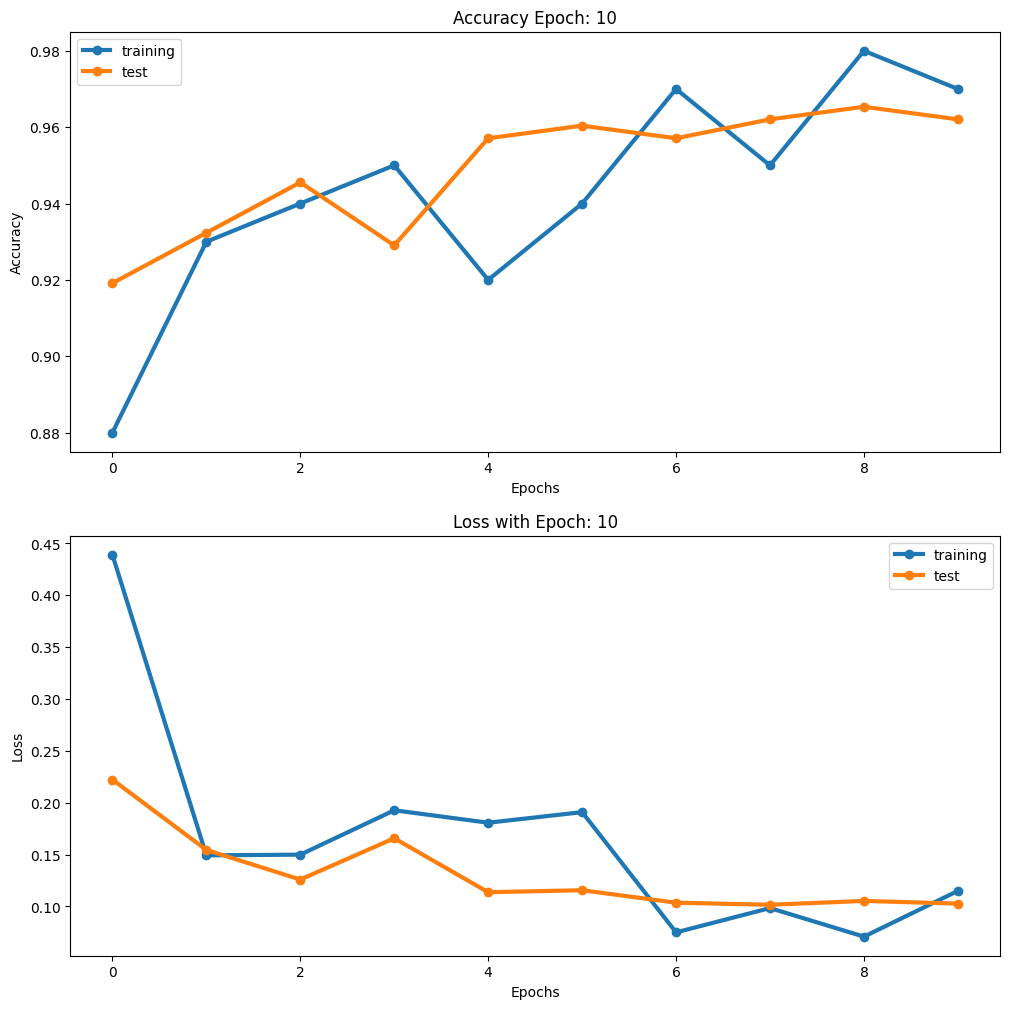

In [12]:
learning_curve(history, plotTitle='Epoch: 10')

## trained with 30 epochs

In [15]:
tf.keras.backend.clear_session()

#Fine-tune model
history=model.fit(
  train_pipeline,
  batch_size=10,
  epochs=30,
  steps_per_epoch=10,
  validation_data=test_pipeline
  )

Epoch 1/30
10/10 [==============================] - 52s 5s/step - loss: 0.0645 - accuracy: 0.9800 - val_loss: 0.1072 - val_accuracy: 0.9620
Epoch 2/30
10/10 [==============================] - 51s 6s/step - loss: 0.0606 - accuracy: 0.9700 - val_loss: 0.1117 - val_accuracy: 0.9637
Epoch 3/30
10/10 [==============================] - 56s 6s/step - loss: 0.0470 - accuracy: 0.9800 - val_loss: 0.1095 - val_accuracy: 0.9620
Epoch 4/30
10/10 [==============================] - 56s 6s/step - loss: 0.1180 - accuracy: 0.9400 - val_loss: 0.1033 - val_accuracy: 0.9653
Epoch 5/30
10/10 [==============================] - 55s 6s/step - loss: 0.0400 - accuracy: 1.0000 - val_loss: 0.0997 - val_accuracy: 0.9653
Epoch 6/30
10/10 [==============================] - 56s 6s/step - loss: 0.0490 - accuracy: 0.9900 - val_loss: 0.0995 - val_accuracy: 0.9653
Epoch 7/30
10/10 [==============================] - 54s 6s/step - loss: 0.0577 - accuracy: 0.9900 - val_loss: 0.0994 - val_accuracy: 0.9653
Epoch 8/30
10/10 [==

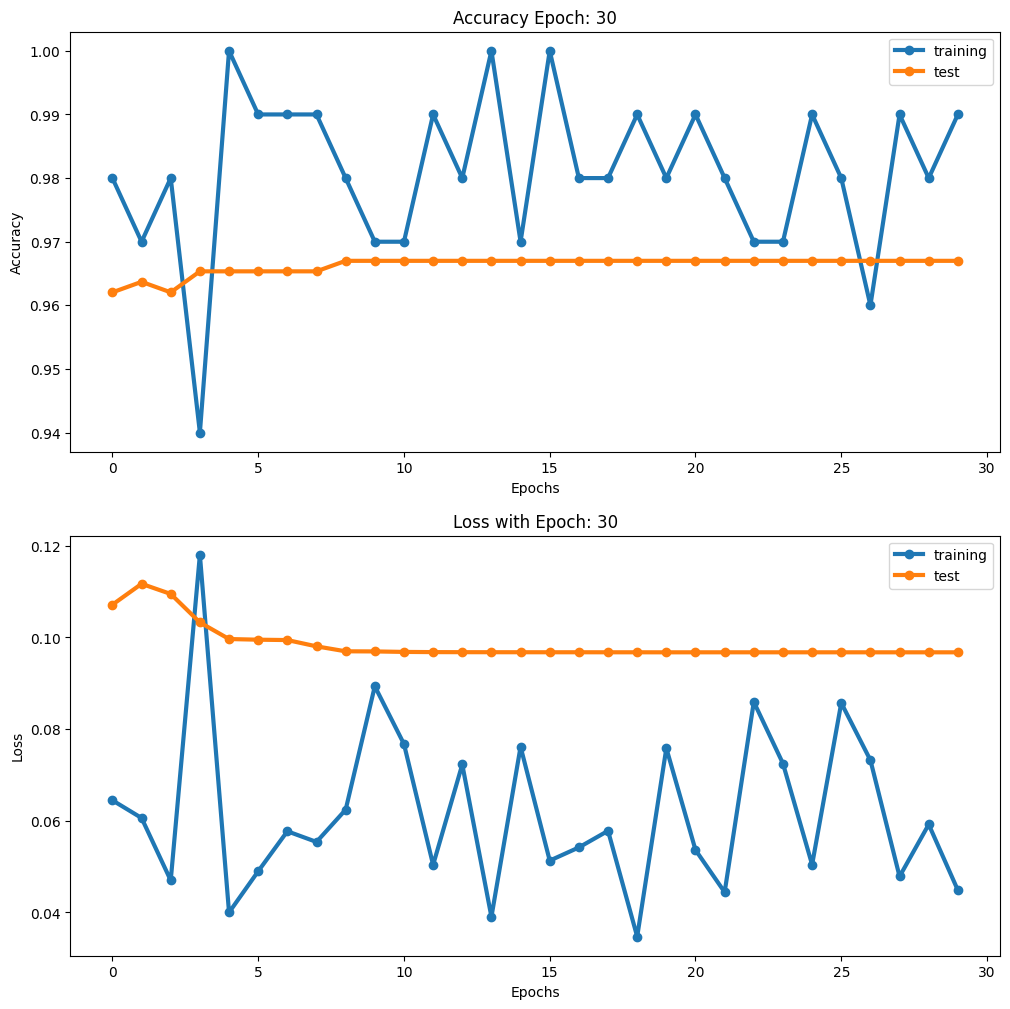

In [16]:
learning_curve(history, plotTitle='Epoch: 30')

## trained with Images rotation

In [17]:
tf.keras.backend.clear_session()

#Preprocess train  images
def preprocess_train(features):
  #Apply horizontal flips
  features['image'] = tf.image.random_flip_left_right(features['image'])
  #Apply vertical  flips
  features['image'] = tf.image.random_flip_up_down(features['image'])
  #Resize
  features['image'] = tf.image.resize(features['image'], [resize_to, resize_to])
  #Apply random crop
  features['image'] = tf.image.random_crop(features['image'], [crop_to, crop_to, 3])
  #Min-max scaling
  features['image'] = tf.cast(features['image'], tf.float32) / (255.0)
  return features


history=model.fit(
  train_pipeline,
  batch_size=10,
  epochs=10,
  steps_per_epoch=10,
  validation_data=test_pipeline
  )

Epoch 1/10
10/10 [==============================] - 48s 5s/step - loss: 0.0681 - accuracy: 0.9700 - val_loss: 0.0968 - val_accuracy: 0.9670
Epoch 2/10
10/10 [==============================] - 46s 5s/step - loss: 0.0873 - accuracy: 0.9600 - val_loss: 0.0968 - val_accuracy: 0.9670
Epoch 3/10
10/10 [==============================] - 55s 6s/step - loss: 0.0673 - accuracy: 0.9900 - val_loss: 0.0968 - val_accuracy: 0.9670
Epoch 4/10
10/10 [==============================] - 62s 7s/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 0.0968 - val_accuracy: 0.9670
Epoch 5/10
10/10 [==============================] - 70s 8s/step - loss: 0.0645 - accuracy: 0.9700 - val_loss: 0.0968 - val_accuracy: 0.9670
Epoch 6/10
10/10 [==============================] - 69s 8s/step - loss: 0.0430 - accuracy: 0.9800 - val_loss: 0.0968 - val_accuracy: 0.9670
Epoch 7/10
10/10 [==============================] - 67s 7s/step - loss: 0.0278 - accuracy: 0.9900 - val_loss: 0.0968 - val_accuracy: 0.9670
Epoch 8/10
10/10 [==

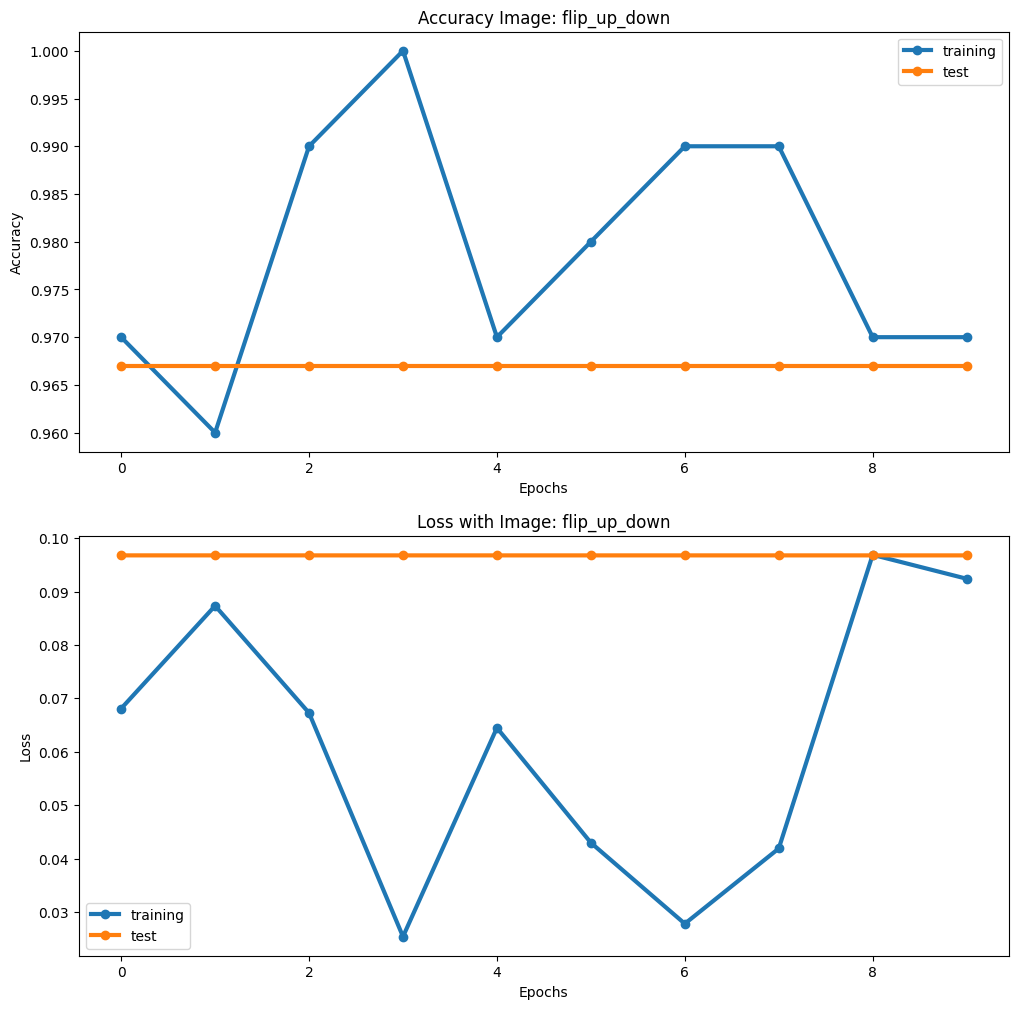

In [18]:
learning_curve(history, plotTitle='Image: flip_up_down')

## trained with Image Grayscale

In [13]:
tf.keras.backend.clear_session()

#Preprocess train  images
def preprocess_train(features):
  #Apply horizontal flips
  features['image'] = tf.image.random_flip_left_right(features['image'])
  #Apply grayscale
  features['image'] = tf.image.rgb_to_grayscale(features['image'])
  #Resize
  features['image'] = tf.image.resize(features['image'], [resize_to, resize_to])
  #Apply random crop
  features['image'] = tf.image.random_crop(features['image'], [crop_to, crop_to, 3])
  #Min-max scaling
  features['image'] = tf.cast(features['image'], tf.float32) / (255.0)
  return features


history=model.fit(
  train_pipeline,
  batch_size=10,
  epochs=10,
  steps_per_epoch=10,
  validation_data=test_pipeline
  )


Epoch 1/10
10/10 [==============================] - 48s 5s/step - loss: 0.0806 - accuracy: 0.9700 - val_loss: 0.0992 - val_accuracy: 0.9587
Epoch 2/10
10/10 [==============================] - 47s 5s/step - loss: 0.0609 - accuracy: 0.9900 - val_loss: 0.1021 - val_accuracy: 0.9637
Epoch 3/10
10/10 [==============================] - 55s 6s/step - loss: 0.1125 - accuracy: 0.9600 - val_loss: 0.1135 - val_accuracy: 0.9571
Epoch 4/10
10/10 [==============================] - 59s 6s/step - loss: 0.0414 - accuracy: 0.9800 - val_loss: 0.1233 - val_accuracy: 0.9521
Epoch 5/10
10/10 [==============================] - 57s 6s/step - loss: 0.2304 - accuracy: 0.9200 - val_loss: 0.1381 - val_accuracy: 0.9422
Epoch 6/10
10/10 [==============================] - 57s 6s/step - loss: 0.0685 - accuracy: 0.9900 - val_loss: 0.0973 - val_accuracy: 0.9653
Epoch 7/10
10/10 [==============================] - 57s 6s/step - loss: 0.0779 - accuracy: 0.9900 - val_loss: 0.1371 - val_accuracy: 0.9505
Epoch 8/10
10/10 [==

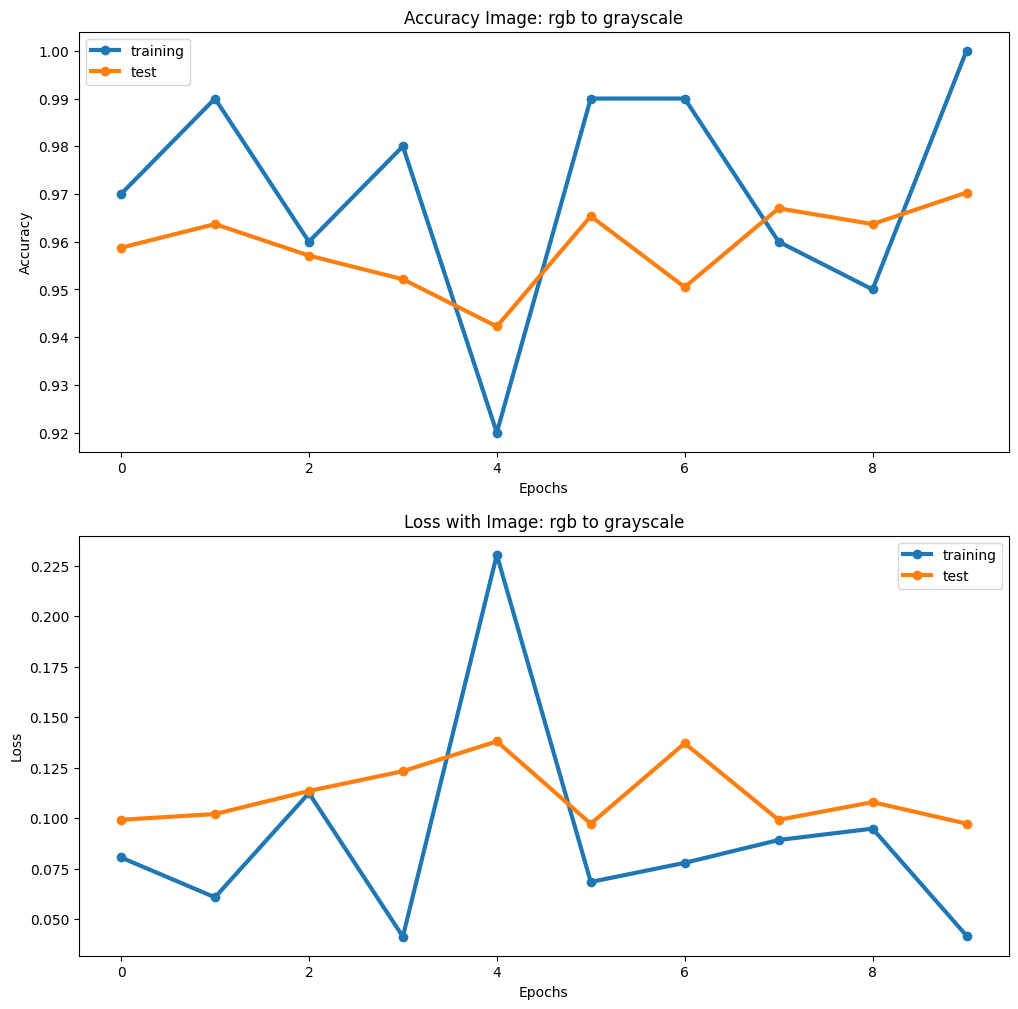

In [14]:
learning_curve(history, plotTitle='Image: rgb to grayscale')